# The Clarke-Wright Savings Algorithm

The Clarke-Wright savings algorithm addresses the Vehicle Routing Problem (VRP), a fundamental challenge in logistics and transportation. In the VRP, we need to design optimal delivery routes from a central depot to serve multiple customers while minimizing the total distance traveled.

The basic version of the problem includes:
- A single depot where all vehicles start and end their routes
- A set of customers with known locations
- A fleet of identical vehicles
- The objective of minimizing total distance traveled

## Algorithm Overview
The Clarke-Wright savings algorithm is a constructive heuristic that builds routes by iteratively combining smaller routes based on maximum savings. The algorithm starts with an initial solution where each customer is served by a dedicated vehicle (depot → customer → depot), then progressively merges routes where the combination yields the greatest savings in distance.

### Key Concepts

1. **Savings Calculation**:
   The savings $s_{ij}$ for combining two routes through customers $i$ and $j$ is:
   $s_{ij} = c_{0i} + c_{0j} - c_{ij}$
   where:
   - $c_{0i}$ is the distance from depot to customer $i$
   - $c_{0j}$ is the distance from depot to customer $j$
   - $c_{ij}$ is the distance between customers $i$ and $j$

2. **Algorithm Steps**:
   1. Calculate savings for all possible pairs of customers
   2. Sort savings in descending order
   3. Starting from the highest savings, merge routes if:
      - Neither customer is internal to an existing route
      - Both customers are at the end of their current routes
      - The merged route remains feasible

The Clarke-Wright savings algorithm was first introduced in: 
>Clarke, G., & Wright, J. W. (1964). Scheduling of Vehicles from a Central Depot to a Number of Delivery Points. Operations Research, 12(4), 568-581.

The following code block imports libraries we will use.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances

sns.set_style('whitegrid')

The following code block generates some random data we will use to demonstrate the algorithm.

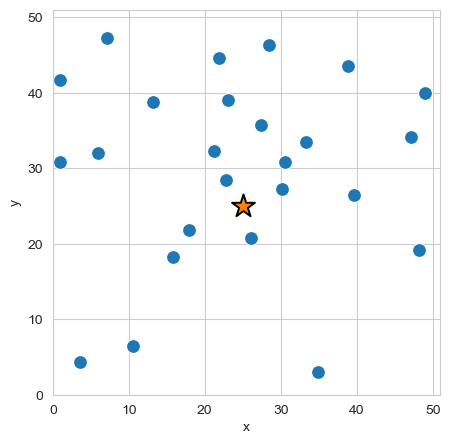

In [2]:
n_locations = 25
location_names = [f'L{i}' for i in range(1, n_locations+1)]

np.random.seed(0)

random_coordinates = np.random.uniform(
    low=0.0,
    high=50.0,
    size=(n_locations, 2)
)
all_coordinates = np.vstack(
    (np.array([25.0, 25.0]), random_coordinates),
)

coordinates_df = pd.DataFrame(
    all_coordinates,
    index=['Depot'] + location_names,
    columns=['x', 'y']
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.scatterplot(
    data=coordinates_df[~coordinates_df.index.isin(['Depot'])],
    x='x',
    y='y',
    s=100,
)

sns.scatterplot(
    data=coordinates_df[coordinates_df.index.isin(['Depot'])],
    x='x',
    y='y',
    s=300,
    marker='*',
    edgecolor='k',
)
ax.set_xlim(0, 51)
ax.set_ylim(0, 51)

plt.show()

The following code block uses the `euclidean_distances` function to create a distance matrix as a `pandas` `DataFrame`.

In [3]:
distance_matrix = pd.DataFrame(
    euclidean_distances(coordinates_df.values),
    index=['Depot'] + location_names,
    columns=['Depot'] + location_names,
)


The following code block specifies the maximum allowable locations on a route.

In [4]:
maximum_route_locations = 10

The following code block computes the savings values.

In [5]:
savings = []
for location1 in location_names:
    for location2 in location_names:
        if location1 < location2:
            sij = (
                distance_matrix.loc['Depot', location1] 
                + distance_matrix.loc['Depot', location2] 
                - distance_matrix.loc[location1, location2]
            )
            savings.append((location1, location2, sij))

savings = sorted(savings, key=lambda x: x[2], reverse=True)

The following code block initializes the routes for each location and creates a dictionary that allows us to easily look up the route assignment for each location.

In [6]:
routes = {f'R{idx}': [location] for idx, location in enumerate(location_names, 1)}

location_to_route = {}
for route, route_locations in routes.items():
    for route_location in route_locations:
        location_to_route[route_location] = route

The following code block implements the Clarke-Wright procedure.

In [7]:
for location1, location2, savings in savings:
    route_location1 = location_to_route[location1]
    route_location2 = location_to_route[location2]
    
    if route_location1 != route_location2:
        potential_combined_route = list(routes[route_location1]) + list(routes[route_location2])
        if len(potential_combined_route) <= maximum_route_locations:
            routes[route_location1] = list(potential_combined_route)
            routes.pop(route_location2)

            location_to_route = {}
            for route, route_locations in routes.items():
                for route_location in route_locations:
                    location_to_route[route_location] = route

The following code block plots the route assignments.

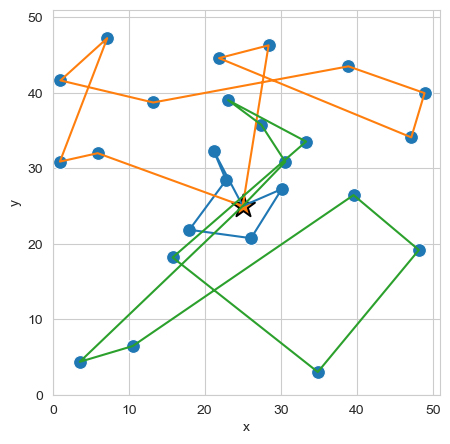

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.scatterplot(
    data=coordinates_df[~coordinates_df.index.isin(['Depot'])],
    x='x',
    y='y',
    s=100,
)

sns.scatterplot(
    data=coordinates_df[coordinates_df.index.isin(['Depot'])],
    x='x',
    y='y',
    s=300,
    marker='*',
    edgecolor='k',
)

for route, route_locations in routes.items():
    x_list = [coordinates_df.loc['Depot', 'x']]
    y_list = [coordinates_df.loc['Depot', 'y']]
    for location in route_locations:
        x_list.append(coordinates_df.loc[location, 'x'])
        y_list.append(coordinates_df.loc[location, 'y'])
    x_list.append(coordinates_df.loc['Depot', 'x'])
    y_list.append(coordinates_df.loc['Depot', 'y'])

    x_tuples = [(v1, v2) for v1, v2 in zip(x_list[:-1], x_list[1:])]
    y_tuples = [(v1, v2) for v1, v2 in zip(y_list[:-1], y_list[1:])]
    ax.plot(
        x_list,
        y_list,
    )

ax.set_xlim(0, 51)
ax.set_ylim(0, 51)

plt.show()

The final step would be to run some procedure to optimize the order that locations are visited on each route, e.g., solve a TSP for each route.